# Time Series Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import statsmodels.api as sm
from datetime import datetime, timedelta
from scipy import stats

In [ ]:
cwd = os.getcwd()
date_format = "%Y-%m-%d"
TORNADO_PATH = os.path.join(cwd, "..", "data/tornadoes/US_tornadoes_2000_2022.csv")
TORNADO_SHAPEFILE = os.path.join(cwd, "..", "data/geographic/US_tornadoes_1950_2022/US_tornadoes_1950_2022.shp")
COUNTIES_PATH = os.path.join(cwd, "..", "data/counties/2018_counties.csv")
COUNTIES_SHAPEFILE = os.path.join(cwd, "..", "data/geographic/cb_2018_us_county_5m/cb_2018_us_county_5m.shp")
INTERSECTION_PATH = os.path.join(cwd, "..", "data/tornado_county_intersections.csv")
PERCENT_PATH = os.path.join(cwd, "..", "data/tornadoes_and_counties_new.csv")
RESULTS_PATH = os.path.join(cwd, "..", "data/results_2000s.csv")
RESULTS_PATH_30s = os.path.join(cwd, "..", "data/results_1930s_to_2020s.csv")

In [199]:
def extractVotes(data_vote, county_set):
    output = []
    for county_id in county_set:
        
        row = data_vote[data_vote["fips"]==county_id]
        # print(data_county)
        votes = row[["dem_two_party_vote_share_1988","dem_two_party_vote_share_1992","dem_two_party_vote_share_1996","dem_two_party_vote_share_2000","dem_two_party_vote_share_2004","dem_two_party_vote_share_2008","dem_two_party_vote_share_2012", "dem_two_party_vote_share_2016"]].values.flatten()
        output.append(votes)
        
    return np.array(output)

def extractMonths(data_tornado, id_set, startDate, endDate, duration):
    output = []
    currentDate = startDate
    
    while currentDate < endDate:
        
        def inBetween(date_str):
            # print(date_str)
            date = datetime.strptime(date_str,date_format)
            return date >= currentDate and date < (currentDate+duration)
        condition_vector = np.vectorize(inBetween)
        condition_mask = condition_vector(data_tornado["date"])
        data_date = data_tornado[condition_mask]
        
        # data_filtered = data_filtered[datetime.strftime(data_filtered["date"],date_format) < startDate+ duration]
        nextRow = []
        for id in id_set:
            data_filtered = data_date[data_date["GEOID"]==id]
            tornadoCount_nonzero = len(data_filtered)
            costAgg = sum(data_filtered["loss"])
            casualties = sum(data_filtered["fat"])+sum(data_filtered["inj"])
            nextRow.append([currentDate, tornadoCount_nonzero,costAgg,casualties])
            
        currentDate = currentDate+duration
        output.append(nextRow)
        print(currentDate)
    
    return np.array(output)


        
        
    
    

In [200]:
def runTimeSeries():
    data_tornado = pd.read_csv(PERCENT_PATH)
    data_vote = pd.read_csv(RESULTS_PATH_30s)
    data_tornado = data_tornado[data_tornado["loss"]>0]
    
    counties = set(data_tornado[data_tornado["yr"]>1985]["GEOID"]).intersection(set(data_vote["fips"]))
    print(counties)
    duration = timedelta(days = 30.4375)
    startTime = datetime.strptime("1989-01-01",date_format)
    endTime = datetime.strptime("2016-12-30",date_format)
    # for county_id in counties:
    countyVotes = extractVotes(data_vote,counties)
    countyTorns = extractMonths(data_tornado,counties, startTime,endTime,duration)
    
    # print(countyVotes)
    # print(countyVotes.shape)
    return countyTorns, countyVotes
    
countyTorns, countyVotes = runTimeSeries()

{41005, 41007, 41009, 41015, 41017, 41019, 41025, 41031, 41035, 41039, 41041, 41043, 41045, 41047, 41049, 41051, 41053, 41057, 41059, 41063, 41067, 41071, 33001, 33003, 33005, 33007, 33009, 33011, 33013, 33015, 33017, 33019, 25001, 25003, 25005, 25009, 25011, 25013, 25015, 25017, 25021, 25023, 25025, 25027, 17001, 17003, 17005, 17007, 17009, 17011, 17013, 17015, 17017, 17019, 17021, 17023, 17025, 17027, 17029, 17031, 17033, 17037, 17039, 17041, 17043, 17045, 17047, 17049, 17051, 17053, 17055, 17057, 17059, 17061, 17063, 17065, 17067, 17069, 17071, 17073, 17075, 17077, 17079, 17081, 17083, 17085, 17087, 17089, 17091, 17093, 17095, 17097, 17099, 17101, 17103, 17105, 17107, 17109, 17111, 17113, 17115, 17117, 17119, 17121, 17123, 17125, 17127, 17129, 17131, 17133, 17135, 17137, 17139, 17141, 17143, 17145, 17147, 17149, 17151, 17153, 17155, 17157, 17159, 17161, 17163, 17165, 17167, 17169, 17171, 17173, 17175, 17177, 17179, 17181, 17183, 17185, 17187, 17189, 17191, 17193, 9001, 17195, 9003, 

In [195]:
print(countyVotes.shape)
print(countyTorns.shape)

def regress_tornadoes(countyIndex, countyVotes, countyTorns):
    startDate = datetime.strptime("1996-01-01",date_format)
    elections = []
    for year in range(1988,2021, 4):
        elections.append(datetime(year=year,day=1,month=1))
    
    
    tornadoMetrics = countyTorns[:,countyIndex,:]
    voteMetrics = countyVotes[countyIndex,:]
    
    
    # plt.scatter(elections,voteMetrics)
    # print(tornadoMetrics[:,0])
    print(tornadoMetrics[:,1])
    fig, axs = plt.subplots(2, figsize=(5,10))
    axs[0].scatter(tornadoMetrics[:,0], tornadoMetrics[:,1])
    axs[1].plot(elections,voteMetrics)
    axs[1].set_ylim([0,1.0])
    axs[1].set_xlim([startDate,elections[-1]])
    
    plt.show()
    
def getAResidual(tornData, lags, edge):
    train_data = tornData[:-edge]
    eval_data = tornData[-edge:]
    # print(train_data)
    ar_model = sm.tsa.AutoReg(train_data,lags=lags).fit()
    predicted = ar_model.predict(start=len(train_data),end=len(train_data+edge))
    
    return eval_data - predicted
    


# print(np.argmax(np.mean(countyTorns[:,:,1],axis= 0)))
print((countyVotes[400]))
print(getAResidual(countyTorns[:,20,3],24,24))

(2830, 9)
(384, 2830, 4)
[0.33824078 0.42648448 0.47555824 0.39477896 0.38425542 0.45863328
 0.3968088  0.26600797 0.26922383]
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0]


-0.0005067701557186247 -0.06011740939791379
0.3821548795030736


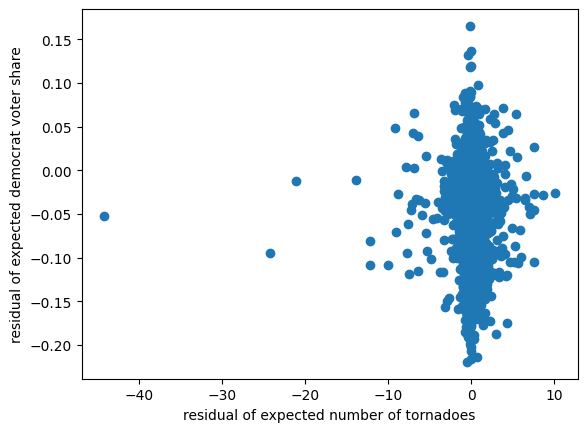

2.0638833120323395e-09 -0.06024304410015078
0.08163878242744121


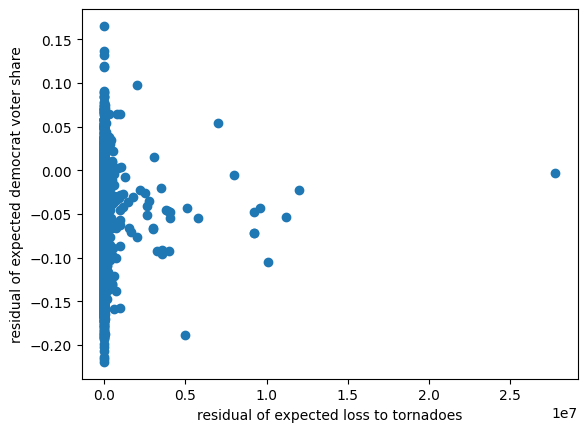

4.229627983033288e-05 -0.06005430517693789
0.14600058510283254


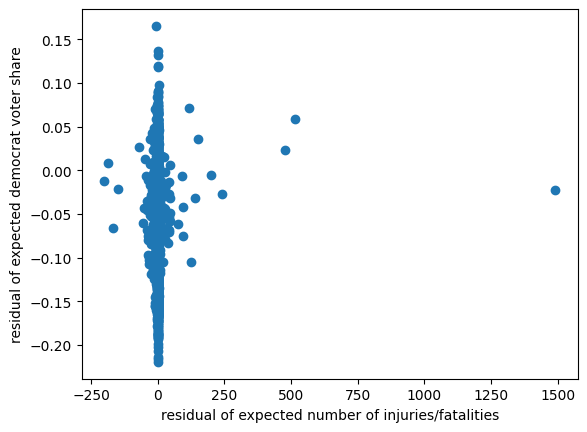

In [241]:
def plotResidualVsTurnout_count(countyVotes,countyTorns):
    resids = []
    votes = []
    for county in range(len(countyVotes)):
        valid = True
        for voteProp in countyVotes[county]:
            if voteProp!=voteProp:
                valid = False
                break
        if not valid:
            continue
        resid = getAResidual(countyTorns[:, county, 1],24,24)
        residSum = sum(resid)
        # voteDiff = abs(getAResidual(countyVotes[county],2,1)[0])
        voteDiff = countyVotes[county][-1] - countyVotes[county][-2]
        # if(residSum<0.01 and residSum>-0.01): continue
        resids.append(residSum)
        votes.append(voteDiff)
    
    plt.scatter(resids,votes)
    # lowess = sm.nonparametric.lowess(votes,resids,frac= 1/3)
    slope,intercept, r_val, p_val, std_rerr = stats.linregress(resids, votes)
    print(slope,intercept)
    print(p_val)
    # plt.plot(lowess[:,0],lowess[:,1],color="red")
    plt.xlabel("residual of expected number of tornadoes")
    plt.ylabel("residual of expected democrat voter share")
    plt.show()
    
    resids = []
    votes = []
    for county in range(len(countyVotes)):
        valid = True
        for voteProp in countyVotes[county]:
            if voteProp!=voteProp:
                valid = False
                break
        if not valid:
            continue
        resid = getAResidual(countyTorns[:, county, 2],24,24)
        residSum = sum(resid)
        # voteDiff = abs(getAResidual(countyVotes[county],2,1)[0])
        voteDiff = countyVotes[county][-1] - countyVotes[county][-2]
        # if(residSum<0.01 and residSum>-0.01): continue
        resids.append(residSum)
        votes.append(voteDiff)
    
    plt.scatter(resids,votes)
    # lowess = sm.nonparametric.lowess(votes,resids,frac= 1/3)
    # plt.plot(lowess[:,0],lowess[:,1],color="red")
    slope,intercept, r_val, p_val, std_rerr = stats.linregress(resids, votes)
    print(slope,intercept)
    print(p_val)
    plt.xlabel("residual of expected loss to tornadoes")
    plt.ylabel("residual of expected democrat voter share")
    plt.show()
    
    resids = []
    votes = []
    for county in range(len(countyVotes)):
        valid = True
        for voteProp in countyVotes[county]:
            if voteProp!=voteProp:
                valid = False
                break
        if not valid:
            continue
        resid = getAResidual(countyTorns[:, county, 3],24,24)
        residSum = sum(resid)
        # voteDiff = abs(getAResidual(countyVotes[county],2,1)[0])
        voteDiff = countyVotes[county][-1] - countyVotes[county][-2]
        # if(residSum<0.01 and residSum>-0.01): continue
        resids.append(residSum)
        votes.append(voteDiff)
    
    plt.scatter(resids,votes)
    # lowess = sm.nonparametric.lowess(votes,resids,frac= 1/3)
    # plt.plot(lowess[:,0],lowess[:,1],color="red")
    slope,intercept, r_val, p_val, std_rerr = stats.linregress(resids, votes)
    print(slope,intercept)
    print(p_val)
    plt.xlabel("residual of expected number of injuries/fatalities")
    plt.ylabel("residual of expected democrat voter share")
    plt.show()

plotResidualVsTurnout_count(countyVotes,countyTorns)
    

0.0005864586840613498 0.06632336424143703
0.22879499547942378


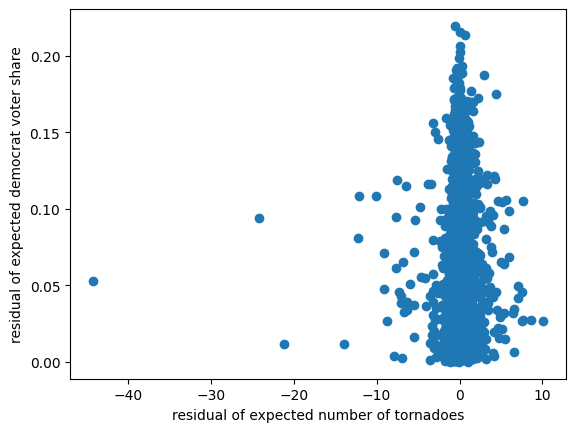

-1.975484703757249e-09 0.06643191110623298
0.04733322530952837


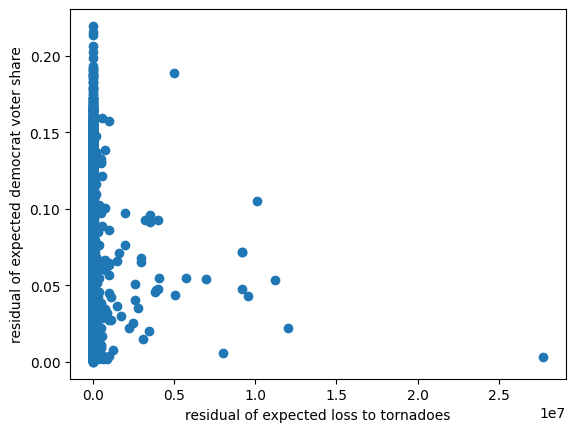

-1.6645164497738745e-05 0.06625384519367007
0.49608439509489166


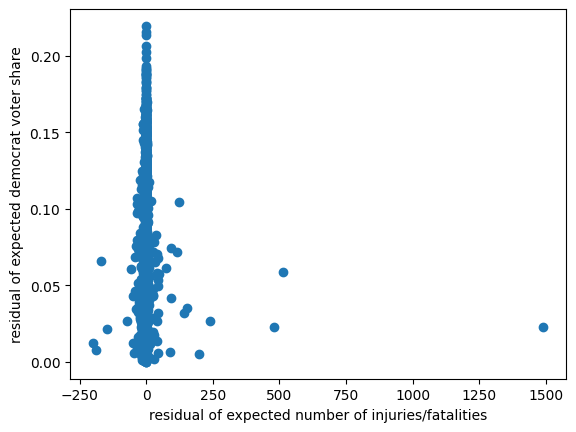

In [242]:
def plotResidualVsTurnout_count(countyVotes,countyTorns):
    resids = []
    votes = []
    for county in range(len(countyVotes)):
        valid = True
        for voteProp in countyVotes[county]:
            if voteProp!=voteProp:
                valid = False
                break
        if not valid:
            continue
        resid = getAResidual(countyTorns[:, county, 1],24,24)
        residSum = sum(resid)
        # voteDiff = abs(getAResidual(countyVotes[county],2,1)[0])
        voteDiff = abs(countyVotes[county][-1] - countyVotes[county][-2])
        # if(residSum<0.01 and residSum>-0.01): continue
        resids.append(residSum)
        votes.append(voteDiff)
    
    plt.scatter(resids,votes)
    # lowess = sm.nonparametric.lowess(votes,resids,frac= 1/3)
    slope,intercept, r_val, p_val, std_rerr = stats.linregress(resids, votes)
    print(slope,intercept)
    print(p_val)
    # plt.plot(lowess[:,0],lowess[:,1],color="red")
    plt.xlabel("residual of expected number of tornadoes")
    plt.ylabel("residual of expected democrat voter share")
    plt.show()
    
    resids = []
    votes = []
    for county in range(len(countyVotes)):
        valid = True
        for voteProp in countyVotes[county]:
            if voteProp!=voteProp:
                valid = False
                break
        if not valid:
            continue
        resid = getAResidual(countyTorns[:, county, 2],24,24)
        residSum = sum(resid)
        # voteDiff = abs(getAResidual(countyVotes[county],2,1)[0])
        voteDiff = abs(countyVotes[county][-1] - countyVotes[county][-2])
        # if(residSum<0.01 and residSum>-0.01): continue
        resids.append(residSum)
        votes.append(voteDiff)
    
    plt.scatter(resids,votes)
    # lowess = sm.nonparametric.lowess(votes,resids,frac= 1/3)
    # plt.plot(lowess[:,0],lowess[:,1],color="red")
    slope,intercept, r_val, p_val, std_rerr = stats.linregress(resids, votes)
    print(slope,intercept)
    print(p_val)
    plt.xlabel("residual of expected loss to tornadoes")
    plt.ylabel("residual of expected democrat voter share")
    plt.show()
    
    resids = []
    votes = []
    for county in range(len(countyVotes)):
        valid = True
        for voteProp in countyVotes[county]:
            if voteProp!=voteProp:
                valid = False
                break
        if not valid:
            continue
        resid = getAResidual(countyTorns[:, county, 3],24,24)
        residSum = sum(resid)
        # voteDiff = abs(getAResidual(countyVotes[county],2,1)[0])
        voteDiff = abs(countyVotes[county][-1] - countyVotes[county][-2])
        # if(residSum<0.01 and residSum>-0.01): continue
        resids.append(residSum)
        votes.append(voteDiff)
    
    plt.scatter(resids,votes)
    # lowess = sm.nonparametric.lowess(votes,resids,frac= 1/3)
    # plt.plot(lowess[:,0],lowess[:,1],color="red")
    slope,intercept, r_val, p_val, std_rerr = stats.linregress(resids, votes)
    print(slope,intercept)
    print(p_val)
    plt.xlabel("residual of expected number of injuries/fatalities")
    plt.ylabel("residual of expected democrat voter share")
    plt.show()

plotResidualVsTurnout_count(countyVotes,countyTorns)